# Surely That Can't Change Sign Back and Forth

## Introduction

In data science, we use the term *concept drift* to describe the situation where the process being modeled has changed characteristics since the time the model was fit. We often express this by saying that the data distribution during application is not the same as the distribution of the original training data. This distribution can be due, for instance, to the arrival of a new population of subjects that mixes with the original population that we modeled.

If we fit a model to the new mixed population, we would expect, of course, a different structure; in the case of a linear model, we'd expect that the coefficients of the new model are different, and perhaps even that some of the coefficients have changed sign. This would mean that a factor `j` which used to correlate positively with outcome, now correlates negatively (or vice versa). If the evolution of the data distribution were gradual, meaning that we start with Population 1, which gets incrementally mixed with a gradually increasing fraction of a second population, we might expect that the change of the model coefficients would also be gradual. In other words, if factor `j` used to correlate positively with outcome (so, for coefficient <code>b<sub>j</sub> > 0</code>), we might expect <code>b<sub>j</sub></code> to become gradually less positive, until it finally switches sign and goes negative. But the reality is more complex than that.

I am going to demonstrate the presumably surprising result that coefficients fit for a linear model can change sign back and forth many times, as data from a *single* new set is mixed into the training data. This effect is a true estimate, and is not due to noise, variance, sampling error, or small data effects.

I think of such analysis as a stab at characterizing models by [model homotopy](https://win-vector.com/tag/probability-model-homotopy/). The idea is: if we treat predictive machine learning models as functions, then these functions have equivalence classes. Some of these classes can be parameterized as continuous deformations, hence ["homotopy"](https://en.wikipedia.org/wiki/Homotopy).


<center>
<img src="./HomotopySmall.gif">
<p/>
<a href="https://commons.wikimedia.org/wiki/File:HomotopySmall.gif">image: Wikimedia, Jim Belk</a>
</center>



Common such data science homotopies include: 

  * Varying regularization parameters (as in the Lasso, [ref](https://win-vector.com/2020/10/12/model-homotopies-in-the-wild/)).
  * Changing positive prevalence in classification ([ref](https://win-vector.com/2020/10/11/tailored-models-are-not-the-same-as-simple-corrections/)).
  * Adding training data (this note).

Data science can be a science, if we take the time to study and refine the methods used. In this note I will explore parameterized families of models, which may help us work out how compatible or incompatible different data sets are. For this note I will explore what happens when we add more training data to a model, creating a concept drift. For this we are not concerned with small data or sampling noise noise. We are concerned with how, when you start taking data from a second source, models change.

## Setup

To illustrate this we set up our Python environment and read in our example data.

In [1]:

import json
import sympy as sp
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from LinRebal_fns import (
    Chebyshev_first_kind,
    engineer_new_ys,
    plot_coefficient_curves,
    plot_curve_annotated,
    plot_linear_diagram,
    plot_poly_curve,
    plot_single_curve,
    solve_by_Cramers_rule,
)

In [2]:
# read in example
with open('ex_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
X1 = np.array(data['X1'])
y1 = np.array(data['y1'])
X2 = np.array(data['X2'])
y2 = np.array(data['y2'])

## Our Example

In [3]:
X1.shape

(10, 6)

In [4]:
(X1, y1)

(array([[1, 6, 0, 2, 3, 3],
        [1, 7, 9, 9, 0, 1],
        [1, 0, 1, 1, 9, 3],
        [1, 1, 4, 5, 8, 6],
        [1, 1, 4, 5, 6, 0],
        [1, 4, 0, 9, 6, 7],
        [1, 5, 3, 3, 1, 2],
        [1, 4, 8, 2, 7, 8],
        [1, 2, 3, 2, 7, 8],
        [1, 2, 0, 2, 1, 0]]),
 array([7, 4, 9, 2, 3, 8, 6, 2, 3, 7]))

In [5]:
(X2, y2)

(array([[1, 4, 4, 4, 4, 9],
        [1, 8, 1, 0, 3, 2],
        [1, 1, 2, 9, 8, 5],
        [1, 3, 0, 8, 0, 3],
        [1, 6, 1, 2, 0, 0],
        [1, 6, 5, 3, 6, 3],
        [1, 2, 6, 2, 5, 5],
        [1, 3, 1, 4, 6, 2],
        [1, 5, 4, 5, 5, 4],
        [1, 4, 9, 9, 5, 0]]),
 array([3, 3, 6, 5, 1, 5, 0, 0, 0, 2]))

### Mixing data

What we will do is start our modeling with the `y1 ~ f(X1)` population and then add in data from a second `y2 ~ f(X2)` population. We go from 100% `y1 ~ f(X1)` data to a mixture where some percentage of the data mass is from each population. The details of this are shown in the function `model_data_mixture()` below.

In [6]:

def model_data_mixture(
    *,
    X1,
    y1,
    X2,
    y2,     
):
    X_both = np.concatenate([X1, X2], axis=0)
    y_both = np.concatenate([y1, y2], axis=0)
    def fit_linear_model(zv: float):
        wts = [1 - zv] * X1.shape[0] + [zv] * X2.shape[0]
        model = LinearRegression(fit_intercept=False)
        model.fit(
            X_both,
            y_both,
            sample_weight=wts
        )
        res_i = pd.DataFrame([zv] + list(model.coef_)).T
        res_i.columns = ['z'] + [f'b[{j}]' for j in range(len(model.coef_))]
        return res_i
    eval_direct = [fit_linear_model(zv) for zv in np.linspace(0, 1, num=201)]
    return pd.concat(eval_direct, ignore_index=True)

Consider the two situations:

  * An initial 100% of the training data coming from the `y1 ~ f(X1)` population (population 1).
  * A final 5% of the data coming from the `y1 ~ f(X1)` population and 50% of the data coming from the `y2 ~ f(x2)` population (population 2). Note: this isn't meant to represent taking less data from population 1, but adding so much data from population 2 that the original data is then a small minority.

The intent is to characterize how a model might evolve as more training data from the second population becomes available. We implemented this as continuous sample weights, as we are studying the concept drift, not studying sample size effects.

Let `z` represent what fraction of our training data is coming from population 2. Let's think of coefficient inference as a function of `z`.

Our two situations recover the following inferred coefficients `b[j]`.

In [7]:
evals = model_data_mixture(
    X1=X1,
    y1=y1,
    X2=X2,
    y2=y2,
)

In [8]:
evals_ends = (
    evals
        .loc[
            (np.abs(evals['z']- 0) < 1e-6) 
            | (np.abs(evals['z']- 0.50) < 1e-6), :]
        .reset_index(drop=True, inplace=False)
)

evals_ends


,z,b[0],b[1],b[2],b[3],b[4],b[5]
0,0.0,4.896506,0.623409,-0.675579,0.022131,0.343974,-0.360305
1,0.5,4.446606,-0.027422,-0.458217,0.184854,0.054416,-0.026953


As expected, the coefficients have changed values, and one has even changed sign. But how do these coefficients evolve as `z` increases?

## The issue

A naive (or at least desired) imagination would be that the coefficients of the intermediate mixtures would interpolate between the two situations (maybe linearly, or at least in a monotone manner) as shown below.


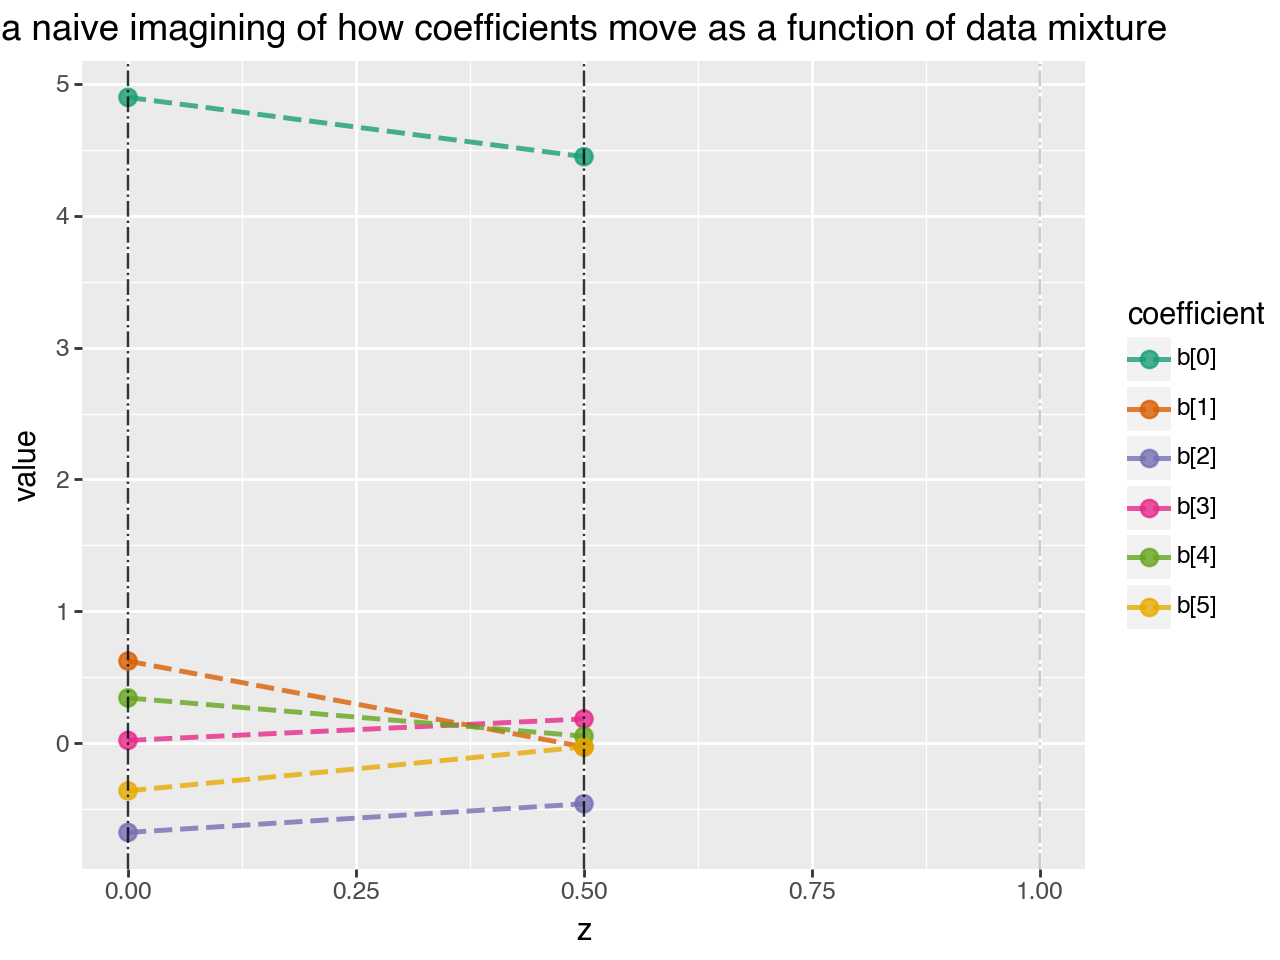

In [9]:

evals_ends_plot = evals_ends.melt(
    id_vars=['z'], 
    var_name='coefficient', 
    value_name='value')

plot_linear_diagram(
    evals_ends_plot
)


However, if we actually look at the intermediate mixture models we see a bit more structure and complexity.

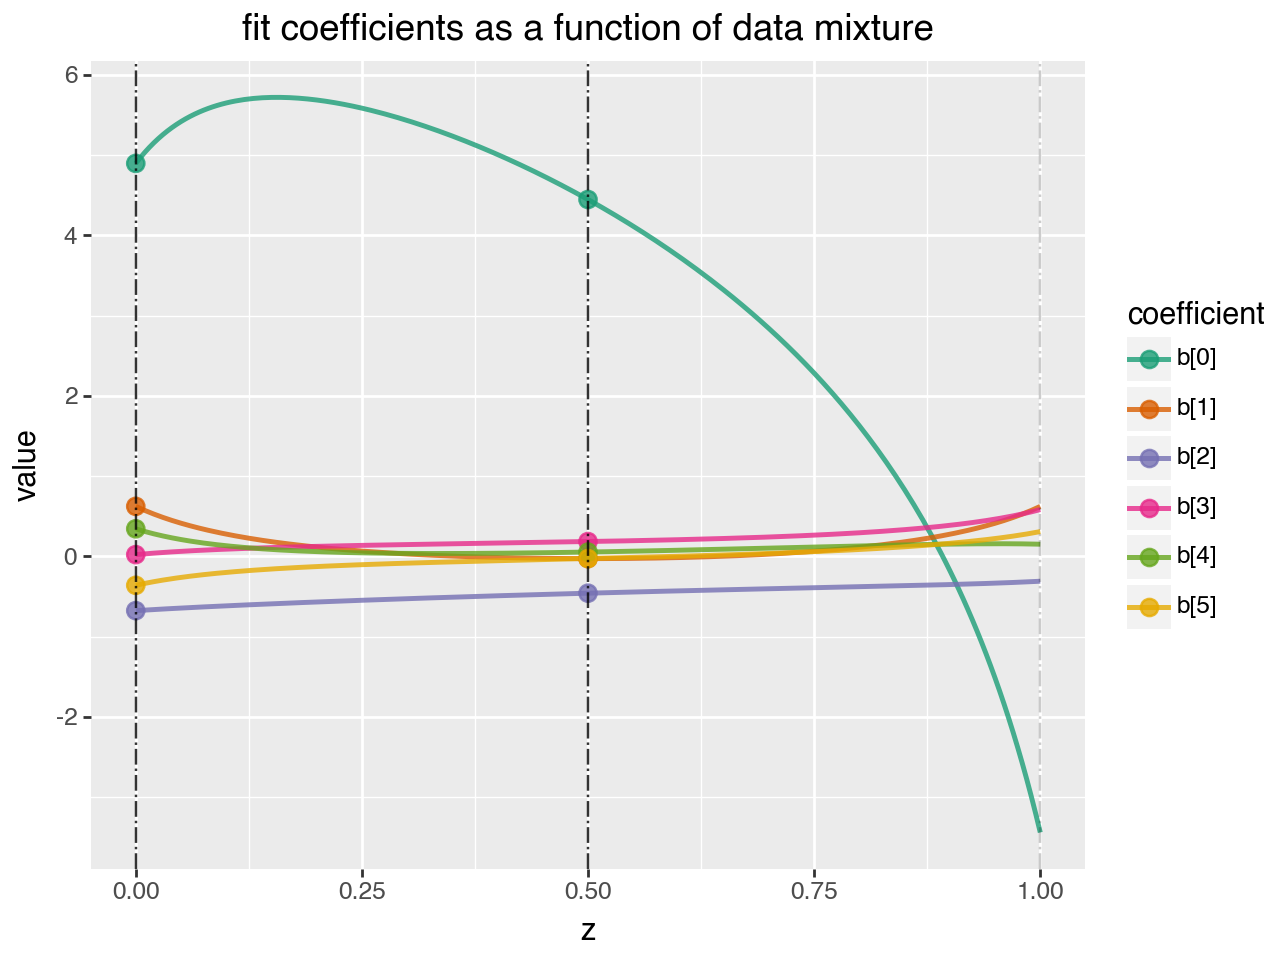

In [10]:

 plot_coefficient_curves(
    evals,
    evals_ends_plot=evals_ends_plot,
    title="fit coefficients as a function of data mixture",
)


The inferred coefficients do not interpolate between the endpoints in a monotone fashion, even for something "as simple as" linear regression. The above is *not* a bug or due to sample size driven noise. The inferred coefficients can in fact reverse behavior as you continue to add more data.

Let's choose a coefficient curve to plot and later alter.

In [11]:
# which coefficient we are going to alter
target_j = 3

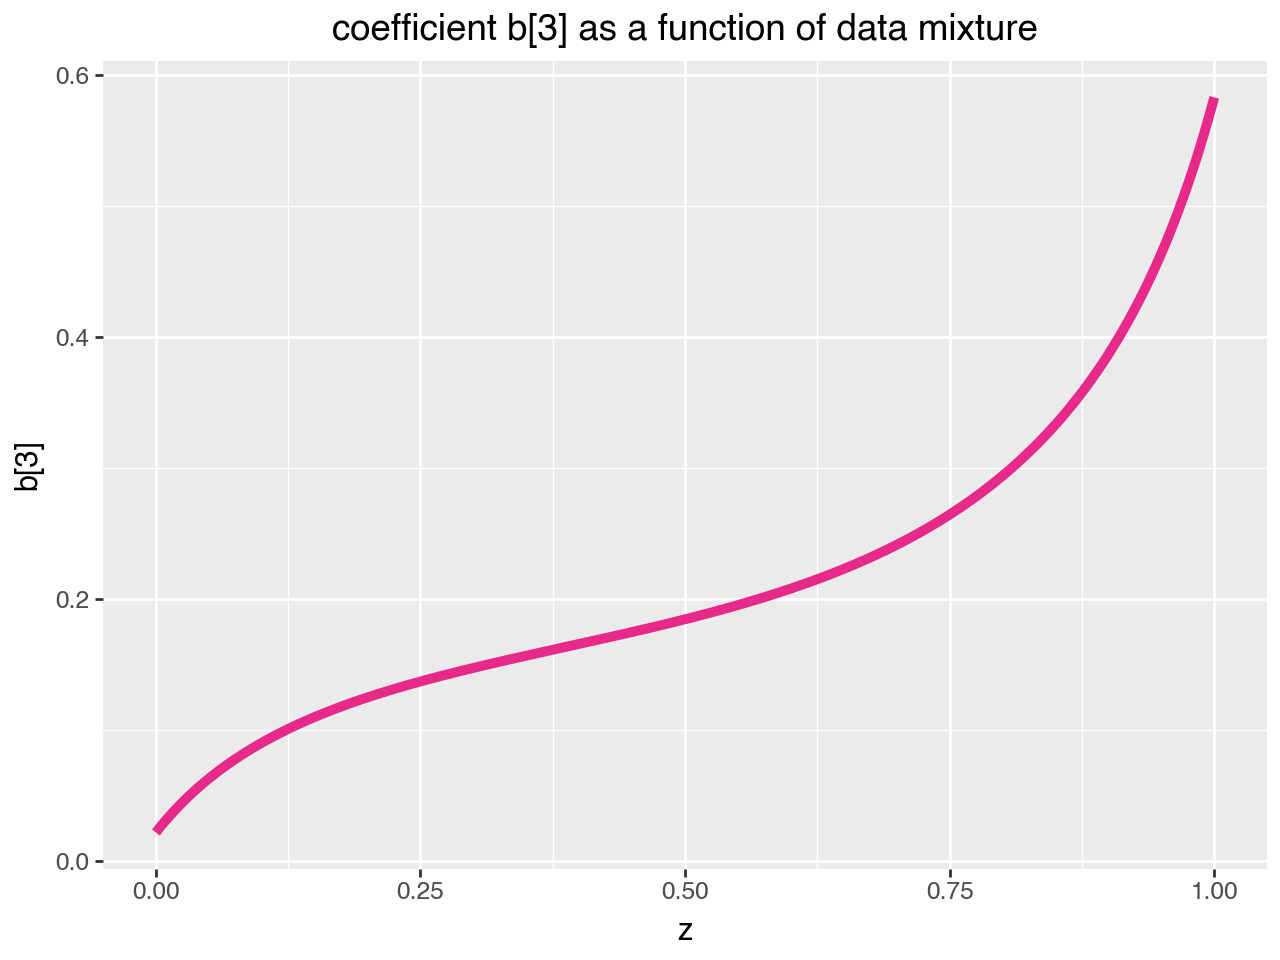

In [12]:
plot_single_curve(
    evals,
    target_j=target_j,
    title=f'coefficient b[{target_j}] as a function of data mixture',
)

Notice `b[3]` moves over a small range in a monotone manner. That is nice. To show the potential issue, we engineer a not-nice situation where `b[3]` changes sign and direction multiple times (by only altering the `y`-outcomes).

## The exact curve structures

Let's work out the exact structure of how the coefficients evolve as the data population mixture changes. Since we are working with a linear system, we can examine this directly by solving directly for the model coefficients using the `sympy` symbolic mathematics engine.

Again, let `z` represent what fraction of our training data is coming from each population.

In [13]:
z = sp.Symbol("z")

XtX = ((1-z) * sp.Matrix(X1.T @ X1)) + (z * sp.Matrix(X2.T @ X2))
Xty = ((1-z) * sp.Matrix(X1.T @ y1)) + (z * sp.Matrix(X2.T @ y2))

soln_num, soln_den = solve_by_Cramers_rule(XtX, Xty)

It turns out that the solution for the `b[]` coefficients is a vector of degree-`k+1` polynomials in `z` (`k` being the number of model coefficients, including the intercept), all divided by a shared polynomial denominator. For our example the solution vector is the following.

In [14]:
display(
    sp.MatMul(1 / sp.Symbol('det'), 
              soln_num.evalf(5), 
              evaluate=False))
display(
    sp.Eq(sp.Symbol('det'), 
          soln_den.evalf(5)))

1/det*Matrix([
[  -3.013*z**6 + 69.877*z**5 - 261.58*z**4 + 84.449*z**3 + 454.15*z**2 - 287.59*z - 37.123],
[   -1.516*z**6 + 3.6837*z**5 + 12.597*z**4 - 25.33*z**3 - 6.1697*z**2 + 17.989*z - 4.7264],
[   1.9658*z**6 - 10.795*z**5 + 17.797*z**4 + 1.7861*z**3 - 32.987*z**2 + 18.832*z + 5.122],
[-1.6093*z**6 + 9.3758*z**5 - 17.385*z**4 + 11.607*z**3 + 3.5267*z**2 - 8.5986*z - 0.16779],
[  1.0332*z**6 - 7.6558*z**5 + 11.891*z**4 + 12.371*z**3 - 30.447*z**2 + 14.568*z - 2.6079],
[   -0.60979*z**6 + 2.4*z**5 + 3.1383*z**4 - 11.047*z**3 + 8.0538*z**2 - 6.3906*z + 2.7317]])

Eq(det, 1.0*z**6 - 0.44407*z**5 - 20.963*z**4 + 30.009*z**3 + 28.161*z**2 - 35.755*z - 7.5816)

We confirm this function agrees with our earlier direct estimates.

In [15]:
# earlier direct "fit the regression" estimates
evals_ends

,z,b[0],b[1],b[2],b[3],b[4],b[5]
0,0.0,4.896506,0.623409,-0.675579,0.022131,0.343974,-0.360305
1,0.5,4.446606,-0.027422,-0.458217,0.184854,0.054416,-0.026953


In [16]:
# estimates from new formula
def check_row(zv: float):
    res =  pd.DataFrame(np.array((
        [[zv]] 
        + [[float(sp.N(v))] 
            for v in (soln_num / soln_den).subs(z, zv)])).T)
    res.columns = ['z'] + [f'b[{j}]' for j in range(res.shape[1] - 1)]
    return res

poly_check = pd.concat([
    check_row(z) for z in evals_ends['z']
], ignore_index=True)

poly_check

,z,b[0],b[1],b[2],b[3],b[4],b[5]
0,0.0,4.896506,0.623409,-0.675579,0.022131,0.343974,-0.360305
1,0.5,4.446606,-0.027422,-0.458217,0.184854,0.054416,-0.026953


In [17]:
# confirm evals agree
assert np.max(np.abs(evals_ends - poly_check)) < 1e-8

By Minkowski's determinant inequality we know the denominator polynomial has no zeros in the range `z = [0, 1]`. So the ratio has no poles.

However, because the numerators are degree-`k` polynomials (`k` being the number of model variables), they may have `k-1` zeros. These estimates are not only nonlinear: they can wiggle up and down `k` times. That is: they can have fairly complex shape.

## A further experiment

If we can pick all of `X1`, `y1`, `X2`, `y2` we can probably specify some fairly arbitrary weird behaviors. Let's leave `X1` and `X2` as they are and see what we can do in picking just `y1` and `y2` "to be weird." It turns out we can place all `k-1` zeros in the range of interest, saying we can in fact get fairly arbitrary shape.

To demonstrate wild shape, we are going to pick a shape for one of the coefficient trajectories and then engineer a new `y1` and `y2` that yield (a somewhat distorted by the shared denominator) version of this shape.

Here is our target trajectory shape.

In [18]:
# our desired trajectory shape
target_poly = Chebyshev_first_kind(XtX.shape[0] - 1, z)
# move area of interest from [-1, 1] to [0, 1]
target_poly = target_poly.subs(z, 2 * z - 1).expand()

target_poly

512*z**5 - 1280*z**4 + 1120*z**3 - 400*z**2 + 50*z - 1

In [19]:
# get the designed roots of the target polynomial
all_target_roots = pd.DataFrame({
    'root': sorted([
        (np.cos(np.pi * (j + 1/2) / (XtX.shape[0] - 1)) + 1) / 2 
        for j in range(XtX.shape[0] - 1)]),
    'crossing': 0,
    })
# confirm our targets are in fact roots
all_target_roots['target_eval'] = [
    float(target_poly.subs({z: zv})) for zv in all_target_roots['root']]
assert np.max(np.abs(all_target_roots['target_eval'])) < 1e-8


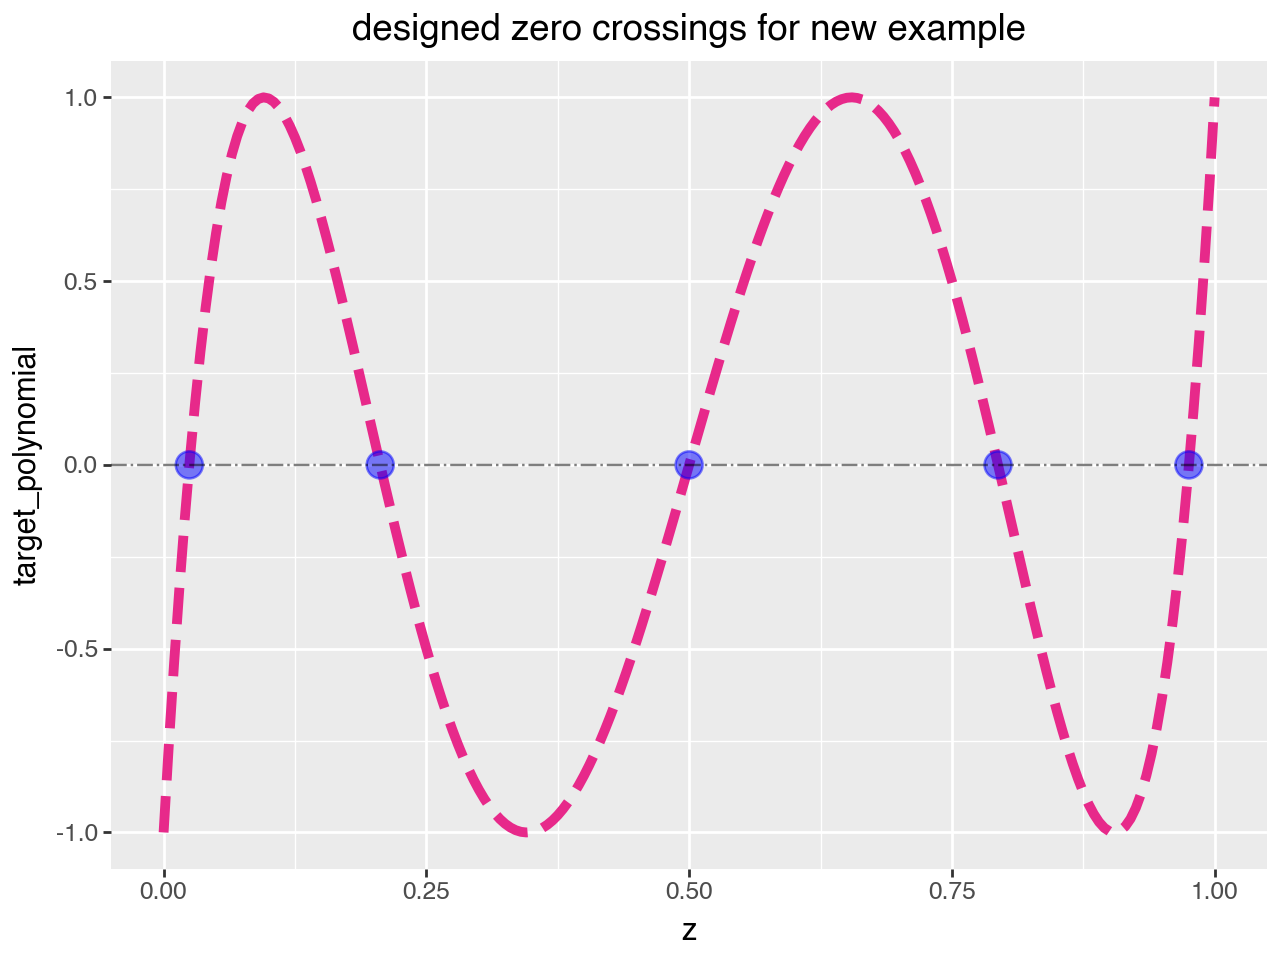

In [20]:
# evaluate and display target polynomial
target_evals = pd.DataFrame({
    'z': np.linspace(0, 1, num=201),
})
target_evals['target_polynomial'] = [
    float(target_poly.subs({z: zv})) for zv in target_evals['z']]
# confirm eval is mostly not near zero
assert np.mean(np.abs(target_evals['target_polynomial']) > 0.5) > 0.5

plot_poly_curve(
    target_evals,
    all_target_roots=all_target_roots,
    target_j=target_j,
)


Now we solve some simultaneous equations to get new `y`s that will place this polynomial in the solution numerator. This yields a (somewhat distorted) copy of our example coefficient trajectory. We are assuming the trajectory changing direction many times is startling, so we chose a shape with this feature as our example. Note: the `y`-only adjustment is ill-conditioned, so the other coefficients are moved quite far.

In [21]:
ys1, ys2 = engineer_new_ys(
    X1=X1,
    y1=y1,
    X2=X2,
    y2=y2,
    target_j=target_j,
    z=z,
    target_poly=100000 * target_poly,  # scale to emphasize shape
)

Let's plot our result for the chosen model coefficient.

In [22]:
eval_eng_direct = model_data_mixture(
    X1=X1,
    y1=ys1,
    X2=X2,
    y2=ys2,
)

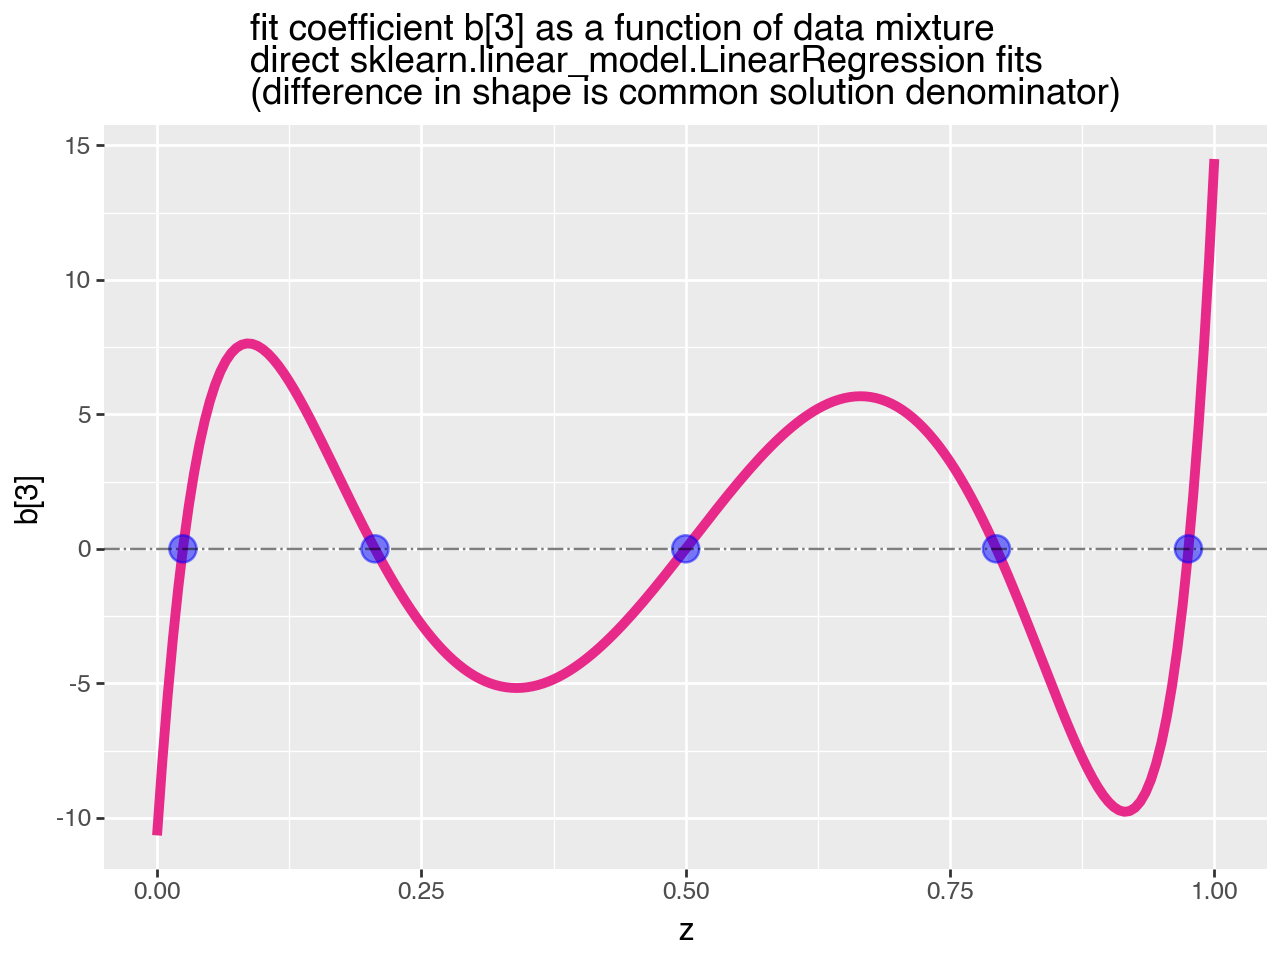

In [23]:
plot_curve_annotated(
    eval_eng_direct,
    all_target_roots=all_target_roots,
    target_j=target_j,
)

In [24]:
# confirm new eval is mostly not near zero
assert np.mean(np.abs(eval_eng_direct[f'b[{target_j}]']) > 1) > 0.5
# confirm signs agree on target polynomial and recovered curve
assert np.min(target_evals['target_polynomial'] * eval_eng_direct[f'b[{target_j}]']) >= 0


We did it: the model coefficient in question has the specified shape that includes 4 reversals in trend! This is akin to a continuous version of [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox). The inferred coefficient is reversing sign (and therefore interpretation) depending on data mixture.

## Conclusion

Even for something "as simple" as a linear regression model, fit coefficients can vary in a non-monotone way with many reversals in trend as we add new training data. This means concept drift can be a bit more complicated than one would hope. The study of how inferred model coefficients vary as we mix data sets can be a measure of how compatible two data sets are. And, the family of all models under the varying of a parameter (a homotopic view) may be stronger description of the modeling situation than a single fit model.
